## Accessing Fit Statistics

We are operating on the same dataset as the first, so let's just load the data and format it just like we did in the other notebook. In this one we'll just look at the spatial profile.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
# import telassar

In [3]:
home = os.path.expanduser("~")
working = os.path.join(home, "telassar")
os.chdir(working)
from telassar import PVSlice

In [4]:
file = os.path.join(working, "data/hd163296_pvslice.fits")
pvdiag = PVSlice(file)

# the OI6300 window
oi6300 = pvdiag.spectral_window(vmin=6288, vmax=6312, unit='angstrom')
lbda1, lbda2 = oi6300.velwave.get_range()
vsys = 5.8

# radial velocity range of the windo
oi_vrad = oi6300.radial_velocity(ref='OI6300', lbdas=[lbda1, lbda2], vcorr=vsys)

## Profiles & Fitting routines

We can also take a cut across a spatial or spectral pixel (or pixels) to look at linear profiles, using either `spatial_profile()` or `spectral_profile()` class methods. If we plot this, it is interactive so we can click on a point to save it as a coordinate. This can be passed to the fitter and a profile can be plotted as well. The fitter can be called separately with the `Modeller` class, or it can be called directly from the `SpecLine` or `SpatLine` instance. 

In cases where there are strong negative residuals, we can also mask values below some threshold to tidy up our plot and fit the data more reliably. For this, we will get the median and the background rms, and subtract an rms factor from the median to get a lower threshold.

In [5]:
from telassar.plotter import get_background_rms

median = oi6300.median()
sig = get_background_rms(oi6300.data, sigma=3)
thresh = median - (4.5 * sig)

oi6300.data[oi6300.data < thresh] = np.ma.masked

In [6]:
%matplotlib notebook

spatial_cut = oi6300.spatial_profile(
    arc=[-1., oi6300.position.get_stop()], 
    wave=[6302, 6306], 
    spat_unit=True, 
    spec_unit=True
)

We are using the same coordinates as before.

In [7]:
# model
coords = [
    (4.4, 1743),
    (8.6, 209),
    (11.4, 692),
    (16, 357),
    (19.2, 180)
]
for offset, flux in coords:
    print("%0.4g \t %0.4g" % (offset, flux))
    


4.4 	 1743
8.6 	 209
11.4 	 692
16 	 357
19.2 	 180


<IPython.core.display.Javascript object>


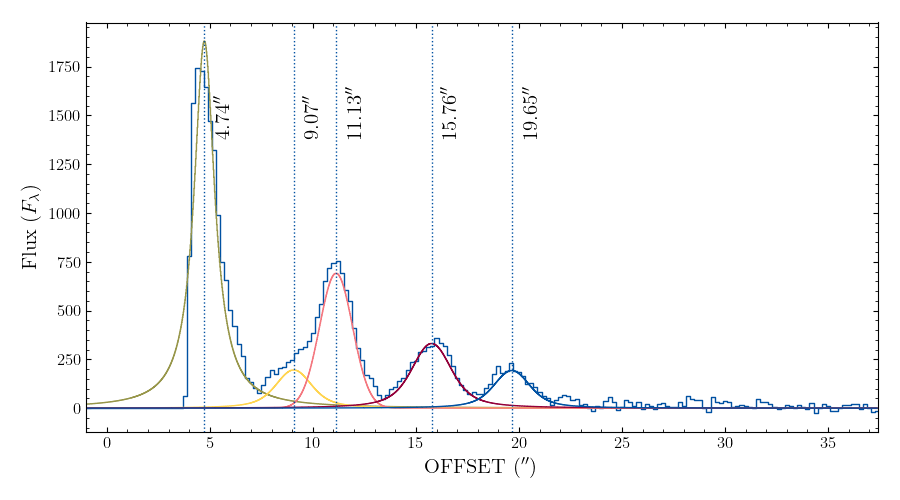

In [8]:
%matplotlib notebook
# from telassar.fitter import Modeller
# del model
model_list = ['l', 'v', 'g', 'v', 'v']
# model = Modeller(spatial_cut)
fitted_model = spatial_cut.fit_model(model_list, coords=coords, plot=True, weight=False)

As we saw in the last notebook, we can simply access the array of basic fit info with `.get_info()`, optionally passing `as_dataframe=True` to return a `pandas` dataframe. If we want a prettier print, we can simply call `.info()`. This will return printed information for each component, as well as the model name and the model number:

In [9]:
# print it prettily
fitted_model.info()


[INFO] Spatial Offset: min: -1.0" max: 37.4" step: 0.200"
[INFO] Fit Info (5 components)
[INFO]  MODEL 0 :  LORENTZIAN
[INFO]     Flux :  5419.07 +/- 179.9
[INFO]     Peak :   3573.7 +/- 118.64
[INFO]     Fwhm :     1.43 +/- 0.06
[INFO]   Center :     4.74 +/- 0.01
[INFO]    Sigma :      0.6 +/- 0.03
[INFO]  MODEL 1 :  VOIGT
[INFO]     Flux :   787.69 +/- 505.45
[INFO]     Peak :   542.95 +/- 348.4
[INFO]     Fwhm :     1.36 +/- 0.74
[INFO]   Center :     9.07 +/- 0.09
[INFO]    Sigma :     0.58 +/- 0.31
[INFO]  MODEL 2 :  GAUSSIAN
[INFO]     Flux :  2771.38 +/- 538.46
[INFO]     Peak :  1383.73 +/- 268.85
[INFO]     Fwhm :     1.88 +/- 0.27
[INFO]   Center :    11.13 +/- 0.05
[INFO]    Sigma :      0.8 +/- 0.11
[INFO]  MODEL 3 :  VOIGT
[INFO]     Flux :   1612.5 +/- 221.31
[INFO]     Peak :  1010.76 +/- 138.72
[INFO]     Fwhm :      1.5 +/- 0.26
[INFO]   Center :    15.76 +/- 0.05
[INFO]    Sigma :     0.64 +/- 0.11
[INFO]  MODEL 4 :  VOIGT
[INFO]     Flux :   781.51 +/- 189.27
[INFO]

The `telassar.fitter.FitStats` class really just wraps around the `lmfit.model.ModelResult` class, possibly unnecessarily. But if wanted the full statistical printout as given by `lmfit`, it's quite simple, and all the methods of that `lmfit` class can be used:

In [10]:
# print(fitted_model.fit_result.fit_report(min_correl=0.8))
fitted_model.fit_result

The `telassar.fitter.FitStats` class can also generate an accessible attribute for each model if we are interested in that, and it returns a dictionary:

In [15]:
from telassar.fitter import FitStats
# instantiate the object
stats = FitStats(fitted_model.fit_result)

# we have five models, so we can access each with `.model_i`
for i in range(5):
    print(getattr(stats, f'model_{i}'), "\n")

{'flux': array([5419.0658698 ,  179.89869303]), 'peak': array([3573.69779512,  118.63734047]), 'fwhm': array([1.42670485, 0.06463761]), 'center': array([4.7354043 , 0.01395451]), 'sigma': array([0.60494609, 0.0274074 ])} 

{'flux': array([787.68533002, 505.44714219]), 'peak': array([542.94760944, 348.40221989]), 'fwhm': array([1.36496767, 0.73924296]), 'center': array([9.07156127, 0.08787447]), 'sigma': array([0.57876852, 0.31345105])} 

{'flux': array([2771.38182784,  538.45543566]), 'peak': array([1383.72544236,  268.84584377]), 'fwhm': array([1.8844038 , 0.26520465]), 'center': array([11.12667527,  0.04760168]), 'sigma': array([0.79901789, 0.11245109])} 

{'flux': array([1612.49659797,  221.30525809]), 'peak': array([1010.76321502,  138.72104565]), 'fwhm': array([1.50098693, 0.25836812]), 'center': array([15.76195814,  0.05190698]), 'sigma': array([0.6364429 , 0.10955229])} 

{'flux': array([781.51213509, 189.27443378]), 'peak': array([536.85750567, 130.02152602]), 'fwhm': array([1.

Creating a separate class here is probably completely unnecessary. However, the main reason for its inclusion is to not only have readily accessible objects for each individual fitted component, but also because for IFU data we often do not use the simple standard error for a fit.

From Porter et al, 2004 (A&A, 428, 327), when dealing with photon counting statistics the error on the fitted centroid is given by the equation:

$$
\sigma = \frac{\rm FWHM}{2 \rm SNR \sqrt{\ln{2}}}
$$